In [1]:
import csv
import numpy as np 
import random
import time
# sve_ivp
import os
import pandas as pd
import matplotlib.pyplot as plt
from Update_LM_functions import calculate_constraints, update_lambda, openfile
from PredictionFunctions import solve_Moments_fn, FoxOn_preds_fn, Moments_Preds_full_fn

In [2]:
on_mac = True
on_thinkpad = False 
on_hpg = False

if on_mac == True: 
    data_path = "/Volumes/hodaakl/"
if on_thinkpad== True: 
    data_path = "//exasmb.rc.ufl.edu/blue/pdixit/hodaakl/"
if on_hpg == True: 
    data_path = "/blue/pdixit/hodaakl/"

# specify the project you are working on     
spec_folder = data_path + 'A5MCMC_IGF_FoxO/'
folder_out = '0120_test_lnx/' #    Lambda = old_lambda.copy() + alpha_arr*(Error)/true_constraints

#    Lambda = old_lambda.copy() + alpha_arr*(Error)/true_constraints
output_dir = spec_folder + folder_out

In [3]:
def Csv_to_Np(index = 0, dat = 'moments' , path = spec_folder + folder_out ): 
    if dat == 'moments':
        fn = path + f'moments_{index}.csv'
    if dat == 'lambdas':
        fn = path + f'Lambdas.csv'
    if dat == 'params': 
        fn = path + f'params_{index}.csv'
    
    df = pd.read_csv(fn, sep = ',', header = None) 
    
    table = df.to_numpy()
    return table
    

### Plotting Max Ent Dynamics. 

I already have the parameters, I can put the parameters in and solve the differential equations as a function of time. For a specific ligand concentration every cell would have a different solution so I will take the mean of those cells. I will have a seperate plot for all the ligand concentrations but I can plot them all on the same plot. I can highlight the constraints that I am using for the max entropy too.  <br> 
Do the same for the actual data, have the actual data in solid lines and the real data in something else. 


In [4]:
t_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L_arr  = np.array([10,15,20,50])*10**-3 #make it in nM
nL = len(L_arr)
nT = len(t_arr)
# 
# read_dictionary = np.load(spec_folder + 'Arrays_for_max_ent/Cons_1208_Zero2ndMoments.npy',allow_pickle='TRUE').item()
# real_cons = read_dictionary['array']
# nCons = len(real_cons)
# read_dictionary
# Conditions_list = read_dictionary['labels']

In [5]:
read_dictionary = np.load(spec_folder + 'Arrays_for_max_ent/MuLnCons_28Conds_0119.npy',allow_pickle='TRUE').item()

real_cons = read_dictionary['array']
nCons = len(real_cons)

In [6]:
#load latest iteration: 
lambda_fn = spec_folder + folder_out + 'Lambdas.csv'
err_fn = spec_folder + folder_out +  'Errors.csv'
df = pd.read_csv(err_fn, sep = ',', header = None) 
err_np = df.to_numpy()
rc_m= np.tile(real_cons[:len(err_np[0,:])] , [err_np.shape[0],1])
# print(rc_m.shape)
mean_err = np.mean(abs(err_np), axis = 1)
# mean_err.shape
real_abs = abs(err_np/rc_m)
mean_rel_abs = np.mean(real_abs, axis = 1)
df_l = pd.read_csv(lambda_fn, sep = ',', header = None)
lambda_np = df_l.to_numpy()
lambda_np.shape
LatestIterI = lambda_np.shape[0] -2
Best_iteration = np.argmin(mean_rel_abs)
# print(Best_iteration)
print('Best_iteration', Best_iteration)
print('LatestIterI', LatestIterI)

Best_iteration 37
LatestIterI 38


In [7]:
lambda_np.shape

(40, 56)

In [14]:
# get the constraints
# best_iter = 26
mom_n= Csv_to_Np(index =Best_iteration, dat ='moments', path = output_dir)
preds = calculate_constraints(mom_n)

In [15]:
mom_n.shape

(1120, 56)

In [16]:
from collections import defaultdict
results_dict = defaultdict(lambda:'not present')


Text(0.5, 1.0, 'Means')

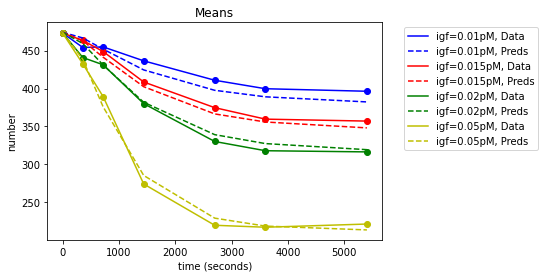

In [17]:
i = 0
color_arr = ['b','r','g','y','purple','k']
for li in range(nL):
    labeldata = f'igf={L_arr[li]}pM, Data, means'
    labelmodel = f'igf={L_arr[li]}pM, Model, means'
    results_dict[labeldata] = real_cons[i:i+nT]
    results_dict[labelmodel] = preds[i:i+nT]
    plt.plot(t_arr,real_cons[i:i+nT], c = color_arr[li], label = f'igf={L_arr[li]}pM, Data')
    plt.scatter(t_arr,real_cons[i:i+nT], c = color_arr[li])
    plt.plot(t_arr,preds[i:i+nT], '--',c = color_arr[li],label = f'igf={L_arr[li]}pM, Preds')
    i=i+nT
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (seconds)')
plt.ylabel('number')
plt.title('Means')

Text(0.5, 1.0, '<log(x)>')

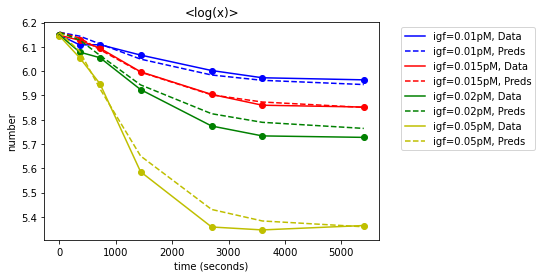

In [18]:
i = 0

color_arr = ['b','r','g','y','purple','k']
for li in range(nL):
#     labeldata = f'igf={L_arr[li]}pM, Data, 2nd moment'
#     labelmodel = f'igf={L_arr[li]}pM, Model, 2nd moment'
    results_dict[labeldata] = real_cons[i+int(nCons/2):i+nT+int(nCons/2)]
    results_dict[labelmodel] = preds[i+int(nCons/2):i+nT+int(nCons/2)]
    plt.plot(t_arr,real_cons[i+int(nCons/2):i+nT+int(nCons/2)], c = color_arr[li], label = f'igf={L_arr[li]}pM, Data')
    plt.scatter(t_arr,real_cons[i+int(nCons/2):i+nT+int(nCons/2)], c = color_arr[li])
    plt.plot(t_arr,preds[i+int(nCons/2):i+nT+int(nCons/2)], '--',c = color_arr[li], label = f'igf={L_arr[li]}pM, Preds')
    i=i+nT
plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('time (seconds)')
plt.ylabel('number')
plt.title('<log(x)>')

In [19]:
results_dict['t_arr'] = t_arr

In [46]:
results_dict = dict(results_dict)
np.save(spec_folder+f'Results_dict_iter{best_iter}_0107.npy', results_dict)

In [47]:
results_dict

{'igf=0.01pM, Data, means': array([473.3266724 , 454.10860632, 454.92797602, 436.5247793 ,
        410.89845591, 399.71709395, 396.37161368]),
 'igf=0.01pM, Model, means': array([477.01296763, 468.43343243, 453.69030261, 427.99135503,
        402.29057621, 393.26745604, 385.15047745]),
 'igf=0.015pM, Data, means': array([473.3266724 , 463.36560404, 448.82085023, 408.61048502,
        374.72214861, 359.57389104, 357.00817722]),
 'igf=0.015pM, Model, means': array([477.01296763, 464.22525385, 442.57304166, 405.96380932,
        371.40035089, 360.05541409, 350.52169424]),
 'igf=0.02pM, Data, means': array([473.3266724 , 440.84614128, 431.31182823, 380.0354967 ,
        330.08426843, 317.88807432, 316.34335599]),
 'igf=0.02pM, Model, means': array([477.01296763, 460.07029246, 431.80077576, 385.4206178 ,
        344.0392098 , 331.32850432, 321.33534901]),
 'igf=0.05pM, Data, means': array([473.3266724 , 432.45472093, 389.35206541, 273.95826841,
        219.50611675, 216.90903078, 221.131886

In [9]:
k_np = Csv_to_Np(index = iter_idx, dat ='params', path = output_dir)

NameError: name 'iter_idx' is not defined

In [ ]:
np.random.randint(0,9,20)

### PIGFR

In [ ]:
len(L_arr)

In [10]:
import random
from collections import defaultdict

In [ ]:
t = 10*60*60
k = k_np[100,:]
result = defaultdict(lambda: 'Not present')
for igf in L_arr:
    sol_dyn, sol =  solve_Moments_fn(K=k, IGF = igf, t = t)
    result
# p_means_arr[ti] += sol[7]

In [ ]:
# k34 = k_np[3,:] - k_np[2,:]

In [ ]:
# 10**np.mean(k34)

In [ ]:
# k_np.shape

In [12]:
## make a dictionary 
k_np = Csv_to_Np(index = LatestIterI, dat ='params', path = output_dir)

t_arr = [0, 6, 12, 25, 45, 60, 90]*60
L_arr  = np.array([10,15,20,25,50,250])*10**-3 #make it in nM
nL = len(L_arr)
nT = len(t_arr)


from collections import defaultdict
## pick 100 values for the k randomly 
nPoints = 100

k_idx = random.sample(range(k_np.shape[0]), nPoints)
k_np_m2_5 = k_np.copy()
k_np_m2_5[:,2] =k_np_m2_5[:,2]- .5


k_np_m2 = k_np.copy()
k_np_m2[:,2] =k_np_m2[:,2]- .2
k_np_p3 = k_np.copy()
k_np_p3[:,3] =k_np_p3[:,3]+ .2


params_dict= {'K2-0.5': k_np_m2_5 ,'K2-0.2': k_np_m2, 'Orig':k_np, 'K3+0.2':k_np_p3}

Full_dict = defaultdict(lambda: 'NotPresent')


# for key in params_dict: 
# I just wanna do the original parameters for now 
for key in ['Orig']: 
    params_database = params_dict[key]
    
    print(key)
    model_dict = defaultdict(lambda: 'NotPresent')


    for igf in L_arr : 
#         print(f'{igf*(1000)}pM')

    #     model_dict[f'{igf*(1000)}pM'] = defaultdict(lambda: 'NotPresent')
        r_means_arr = np.zeros(nT)
        b_means_arr = np.zeros(nT)
        p_means_arr = np.zeros(nT)
        pakt_means_arr = np.zeros(nT)
        f_means_arr = np.zeros(nT)

        for ki in k_idx: 
            kk = params_database[ki,:]

    #         print(ko == kk)

            for ti in range(nT):

                tend = t_arr[ti]
    #             print(ko == kk)

    #             _, sol =  solve_Moments_fn(K=kk, IGF = igf, tend = tend)
                _, sol =  solve_Moments_fn(K=kk, IGF = igf, t = tend)

                r_means_arr[ti] += sol[0].copy()
                b_means_arr[ti] += sol[1].copy()
                p_means_arr[ti] += sol[2].copy()
                pakt_means_arr[ti] += sol[4].copy()
                f_means_arr[ti] += sol[7].copy()


#         print(p_means_arr)
        model_dict[f'{igf*(1000)}pM'] =  {'R': r_means_arr/nPoints, 'pAKT': pakt_means_arr/nPoints, 'B': b_means_arr/nPoints, 'P': p_means_arr/nPoints, 'FoxO':f_means_arr/nPoints} 
        
    Full_dict[key] = dict(model_dict)

Orig


In [ ]:
Full_dict


In [ ]:
i = 0
color_arr = ['b','r','g','y','purple','k']
constraints_dict = defaultdict(lambda:'Not Present')
for li in range(nL-1):
    LigandConc = L_arr[1+li]
    constraints_dict[f'{LigandConc*1000}pM'] = real_cons[i:i+nT]
    i=i+nT
i-nT

In [ ]:
colorlist = ['k', 'purple','r', 'b', 'g' , 'orange', 'pink']
fig, axs = plt.subplots(4,4, figsize = (20,15))

ii = 0
jj = 0 
x = t_arr/60 
for params_description in Full_dict: 
    ci = 0
    
    for ligand_conc in Full_dict[params_description]:
#         print(ligand_conc)
#         print(jj)
#         print(ci)
        axs[0,jj].plot(x,Full_dict[params_description][ligand_conc]['R'], c = colorlist[ci], label = ligand_conc)
        axs[0,jj].scatter(x,Full_dict[params_description][ligand_conc]['R'],c = colorlist[ci])
        axs[1,jj].plot(x,Full_dict[params_description][ligand_conc]['B'],c = colorlist[ci])
        axs[1,jj].scatter(x,Full_dict[params_description][ligand_conc]['B'],c = colorlist[ci])
        axs[2,jj].plot(x,Full_dict[params_description][ligand_conc]['P'],c = colorlist[ci])
        axs[2,jj].scatter(x,Full_dict[params_description][ligand_conc]['P'],c = colorlist[ci])
        axs[3,jj].plot(x,Full_dict[params_description][ligand_conc]['FoxO'],c = colorlist[ci])
        axs[3,jj].scatter(x,Full_dict[params_description][ligand_conc]['FoxO'],c = colorlist[ci])
        if ligand_conc != '0.0pM':
            axs[3,jj].plot(x,constraints_dict[ligand_conc], '--',c = colorlist[ci])
            axs[3,jj].scatter(x,constraints_dict[ligand_conc], c = colorlist[ci])
        
#         jj+=1
        ci+=1
    
    
    
    jj+=1
axs[0,3].legend(loc = "upper right",prop={'size': 14})
    
plt.tight_layout()
    

### Some more things to plot
1. P vs IGF 
2. pAKT vs P 
3. FoxO vs pAKT <br>
This can be done for K3 - 0.5 (we can do that at steady state, so we can say last time point)

In [ ]:
Full_dict

In [ ]:
species_key_list = ['R', 'pAKT', 'B', 'P', 'FoxO']
rel_dict = Full_dict['Orig']
# 
R_arr =np.zeros(nL)
B_arr =np.zeros(nL)
P_arr =np.zeros(nL)
pAKT_arr =np.zeros(nL)
FoxO_arr =np.zeros(nL)



i = 0 
# j=0
for key in rel_dict:
    R_arr[i] = rel_dict[key]['R'][-1]
    B_arr[i] = rel_dict[key]['B'][-1]
    P_arr[i] = rel_dict[key]['P'][-1]
    pAKT_arr[i] = rel_dict[key]['pAKT'][-1]
    FoxO_arr[i] = rel_dict[key]['FoxO'][-1]
    
    i+=1
    
    

In [ ]:
pAKT_arr

In [ ]:
plt.scatter(np.log10(L_arr), P_arr)
plt.title('P')
plt.xlabel('Log(ligand Concentration)')
plt.ylabel('Number')
plt.show()

plt.scatter(P_arr, pAKT_arr)
plt.title('pAKT vs P')
plt.xlabel('P')
plt.ylabel('pAKT')
plt.show()

plt.scatter(pAKT_arr, FoxO_arr)
plt.title('FoxO vs pAKT')
plt.xlabel('pAKT')
plt.ylabel('FoxO')
plt.show()

In [ ]:
constraints_dict

In [ ]:
Full_dict['K2-0.2']['10.0pM']['FoxO'] == Full_dict['K3+0.2']['10.0pM']['FoxO']


In [ ]:
i = 0
color_arr = ['b','r','g','y','purple','k']
for li in range(nL):
    plt.plot(t_arr,real_cons[i:i+nT], c = color_arr[li], label = f'igf={L_arr[li]}pM, Data')
    plt.scatter(t_arr,real_cons[i:i+nT], c = color_arr[li])
    plt.plot(t_arr,preds[i:i+nT], '--',c = color_arr[li],label = f'igf={L_arr[li]}pM, Preds')
    i=i+nT
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (min)')
plt.ylabel('number')
plt.title('Means')

In [ ]:
real_cons


In [ ]:
L_arr

In [ ]:
i = 0
color_arr = ['b','r','g','y','purple','k']
constraints_dict = defaultdict(lambda:'Not Present')
for li in range(nL-1):
    LigandConc = L_arr[1+li]
    constraints_dict[f'{LigandConc*1000}pM'] = real_cons[i:i+nT]
    i=i+nT
i-nT

In [ ]:
constraints_dict = dict(constraints_dict)

In [ ]:
constraints_dict